<a href="https://colab.research.google.com/github/erneyurrego-art/Introducci-n-a-la-IA/blob/main/05_entrenamiento_con_Caatboots_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Modelo de Machine Learning - Entrenamiento con Caatboots

En este colab se pasara a desarrollar todo el ciclo de vida de un modelo de machine learning, desde la inspección de los datos, limpieza y transformación y finalmente el entrenamiento del modelo. y Finalmente arrojando el archivo csv para enviar a la competencia de kaggle.

## Inspección de los datos

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, OrdinalEncoder

In [7]:
try:
    d = pd.read_csv('train.csv', on_bad_lines='skip')
    display(d.head())
except Exception as e:
    print(f"An error occurred: {e}")

,ID,PERIODO_ACADEMICO,E_PRGM_ACADEMICO,E_PRGM_DEPARTAMENTO,E_VALORMATRICULAUNIVERSIDAD,E_HORASSEMANATRABAJA,F_ESTRATOVIVIENDA,F_TIENEINTERNET,F_EDUCACIONPADRE,F_TIENELAVADORA,...,E_PRIVADO_LIBERTAD,E_PAGOMATRICULAPROPIO,F_TIENECOMPUTADOR,F_TIENEINTERNET.1,F_EDUCACIONMADRE,RENDIMIENTO_GLOBAL,INDICADOR_1,INDICADOR_2,INDICADOR_3,INDICADOR_4
0,904256,20212,ENFERMERIA,BOGOTÁ,Entre 5.5 millones y menos de 7 millones,Menos de 10 horas,Estrato 3,Si,Técnica o tecnológica incompleta,Si,...,N,No,Si,Si,Postgrado,medio-alto,0.322,0.208,0.310,0.267
1,645256,20212,DERECHO,ATLANTICO,Entre 2.5 millones y menos de 4 millones,0,Estrato 3,No,Técnica o tecnológica completa,Si,...,N,No,Si,No,Técnica o tecnológica incompleta,bajo,0.311,0.215,0.292,0.264
2,308367,20203,MERCADEO Y PUBLICIDAD,BOGOTÁ,Entre 2.5 millones y menos de 4 millones,Más de 30 horas,Estrato 3,Si,Secundaria (Bachillerato) completa,Si,...,N,No,No,Si,Secundaria (Bachillerato) completa,bajo,0.297,0.214,0.305,0.264
3,470353,20195,ADMINISTRACION DE EMPRESAS,SANTANDER,Entre 4 millones y menos de 5.5 millones,0,Estrato 4,Si,No sabe,Si,...,N,No,Si,Si,Secundaria (Bachillerato) completa,alto,0.485,0.172,0.252,0.190
4,989032,20212,PSICOLOGIA,ANTIOQUIA,Entre 2.5 millones y menos de 4 millones,Entre 21 y 30 horas,Estrato 3,Si,Primaria completa,Si,...,N,No,Si,Si,Primaria completa,medio-bajo,0.316,0.232,0.285,0.294


In [8]:
d.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 692500 entries, 0 to 692499
Data columns (total 21 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   ID                           692500 non-null  int64  
 1   PERIODO_ACADEMICO            692500 non-null  int64  
 2   E_PRGM_ACADEMICO             692500 non-null  object 
 3   E_PRGM_DEPARTAMENTO          692500 non-null  object 
 4   E_VALORMATRICULAUNIVERSIDAD  686213 non-null  object 
 5   E_HORASSEMANATRABAJA         661643 non-null  object 
 6   F_ESTRATOVIVIENDA            660363 non-null  object 
 7   F_TIENEINTERNET              665871 non-null  object 
 8   F_EDUCACIONPADRE             669322 non-null  object 
 9   F_TIENELAVADORA              652727 non-null  object 
 10  F_TIENEAUTOMOVIL             648877 non-null  object 
 11  E_PRIVADO_LIBERTAD           692500 non-null  object 
 12  E_PAGOMATRICULAPROPIO        686002 non-null  object 
 13 

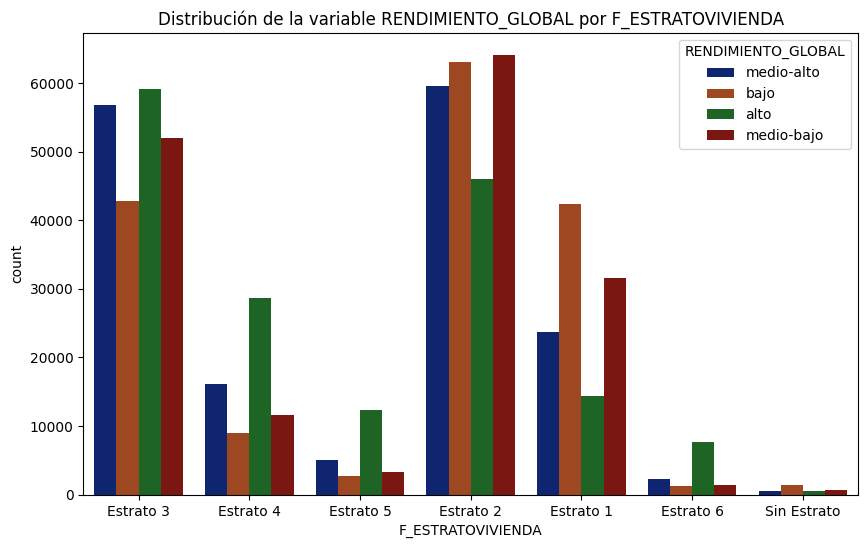

In [9]:
# distribución de la variable objetivo por el estracto de la vivienda

plt.figure(figsize=(10, 6))
sns.countplot(x ="F_ESTRATOVIVIENDA", hue="RENDIMIENTO_GLOBAL", data=d, palette="dark")
plt.title("Distribución de la variable RENDIMIENTO_GLOBAL por F_ESTRATOVIVIENDA")
plt.show()

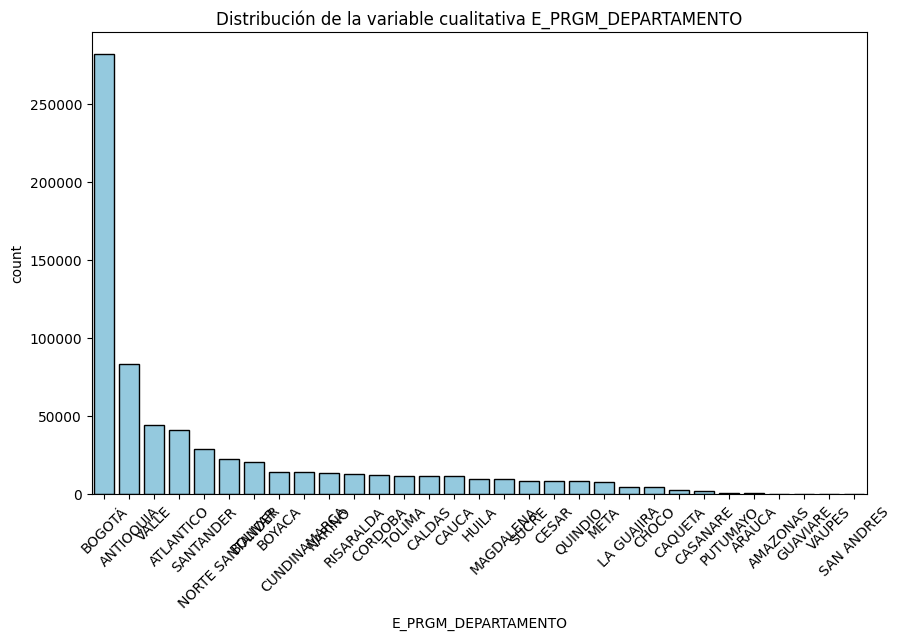

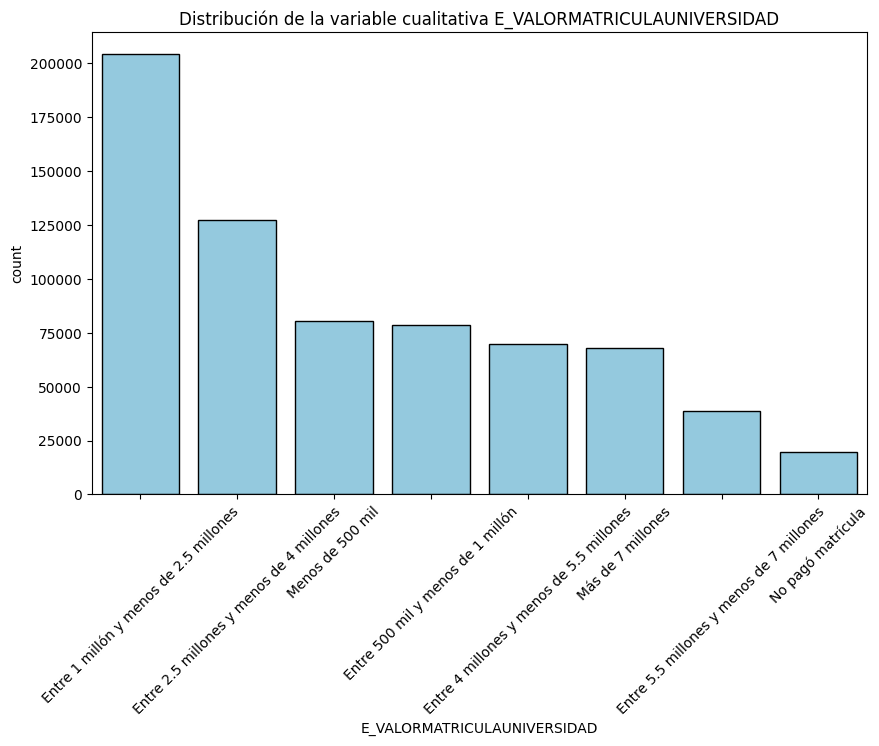

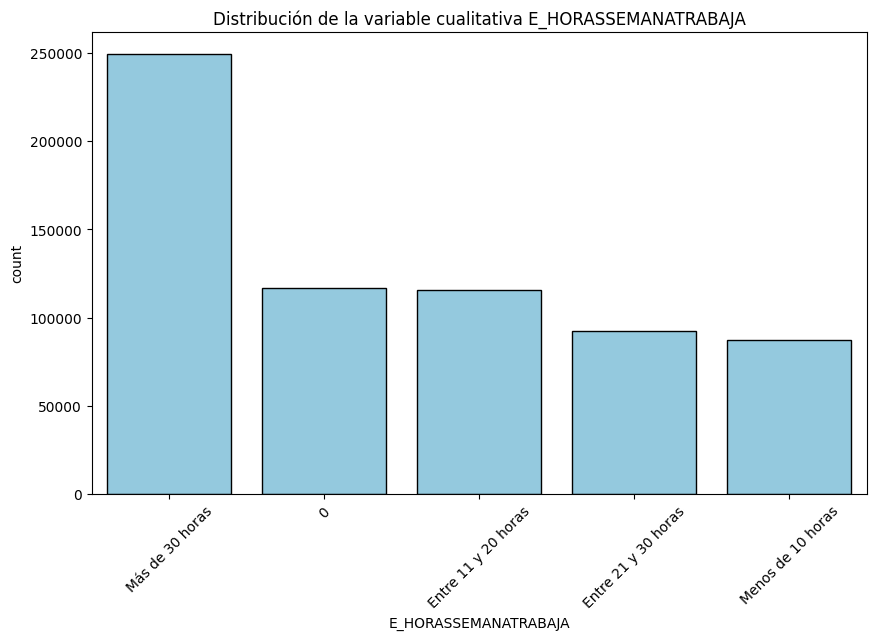

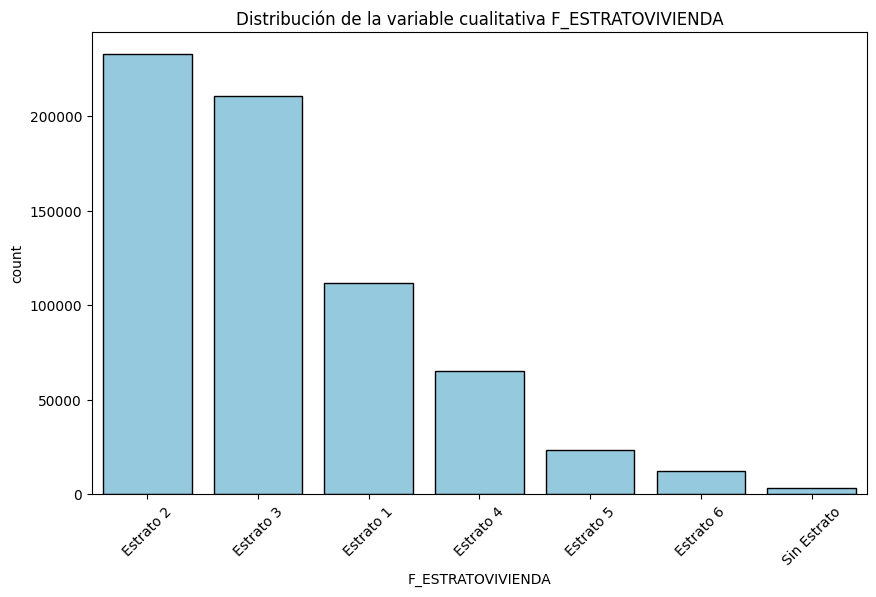

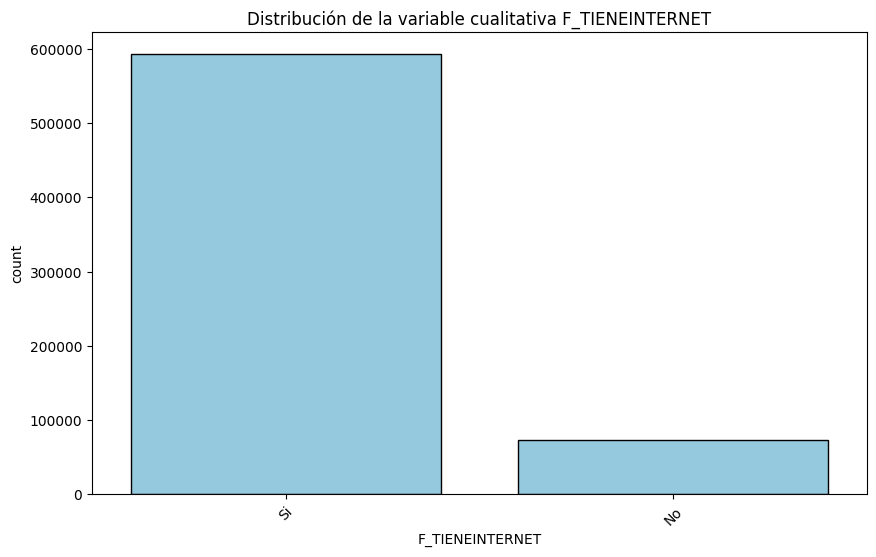

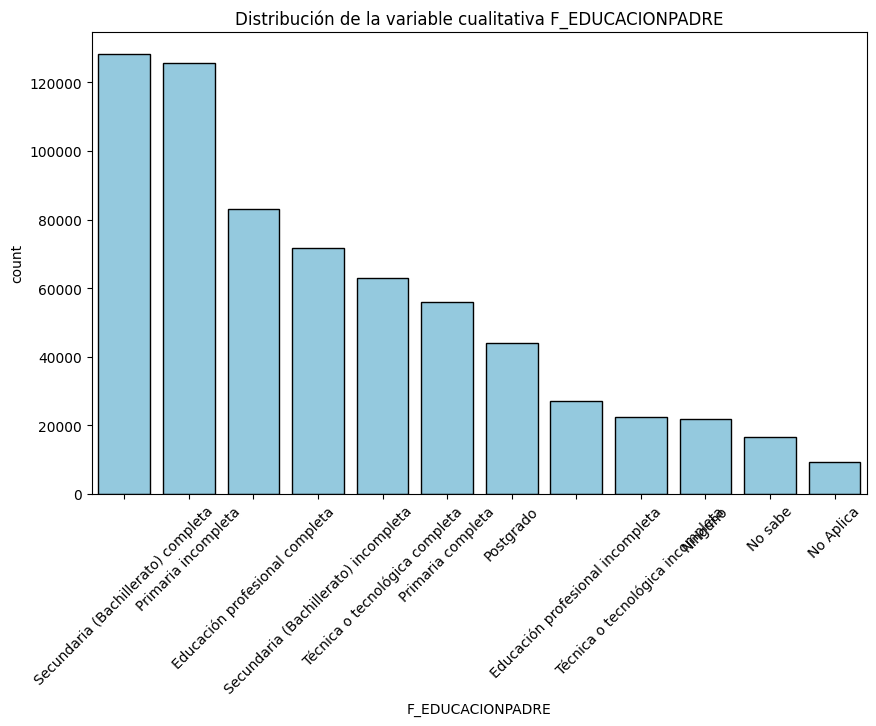

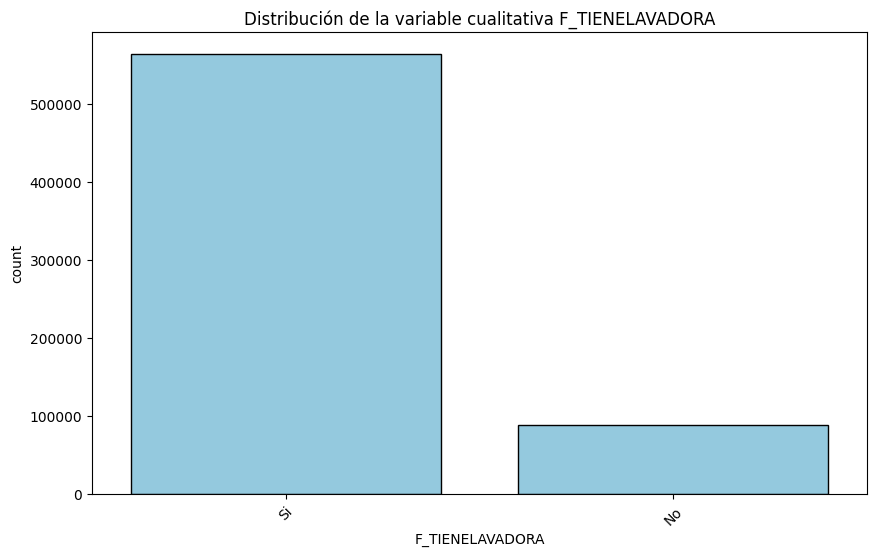

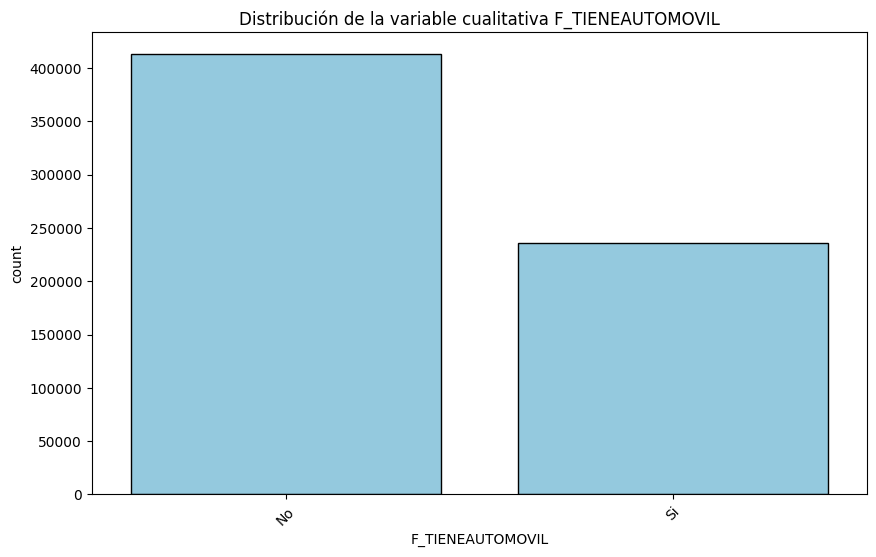

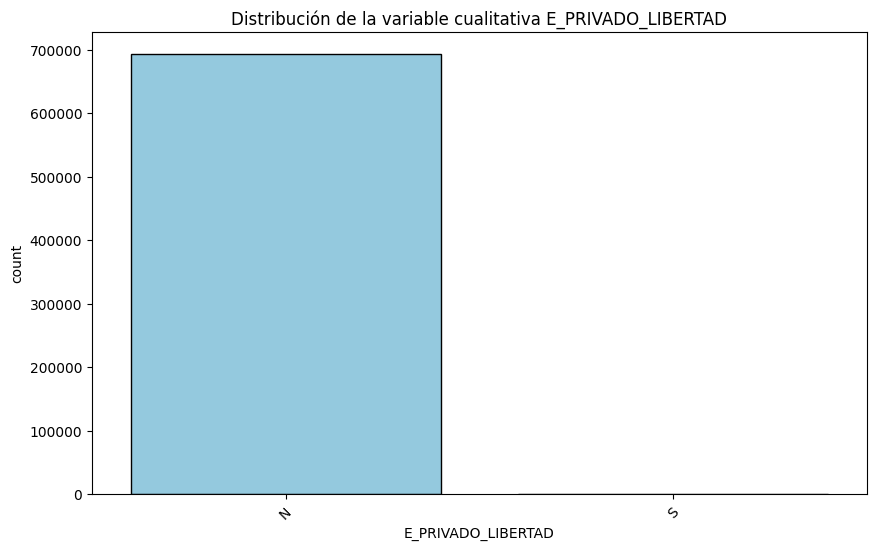

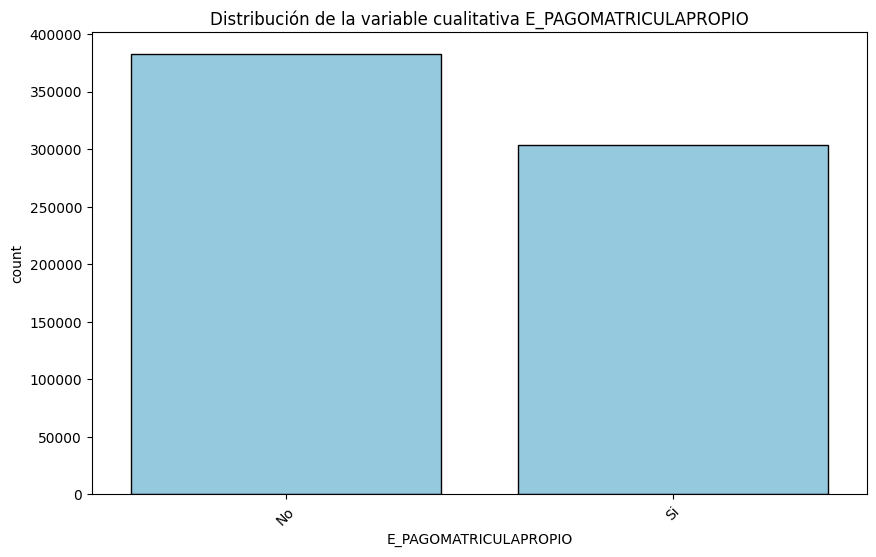

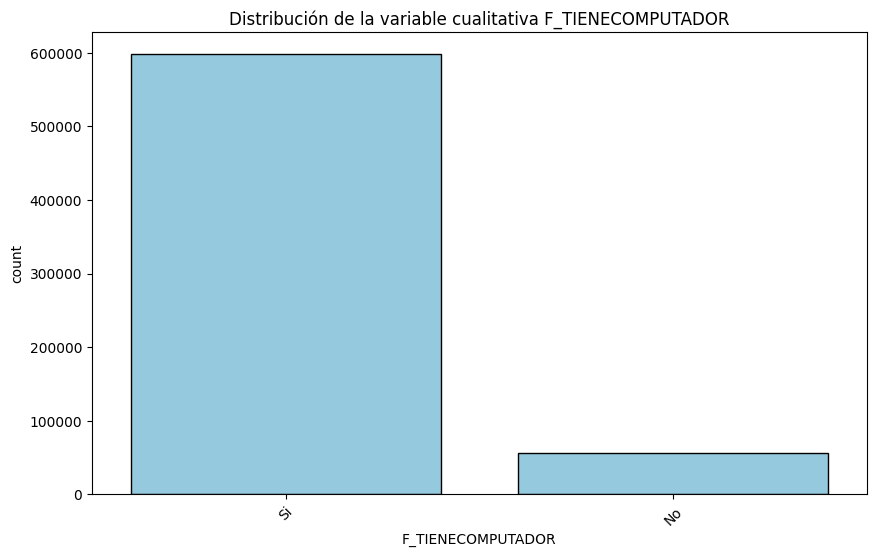

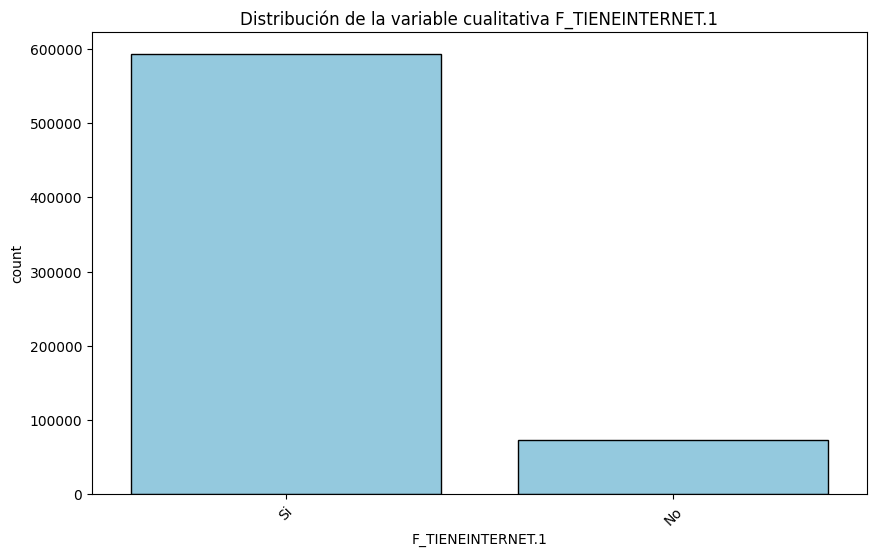

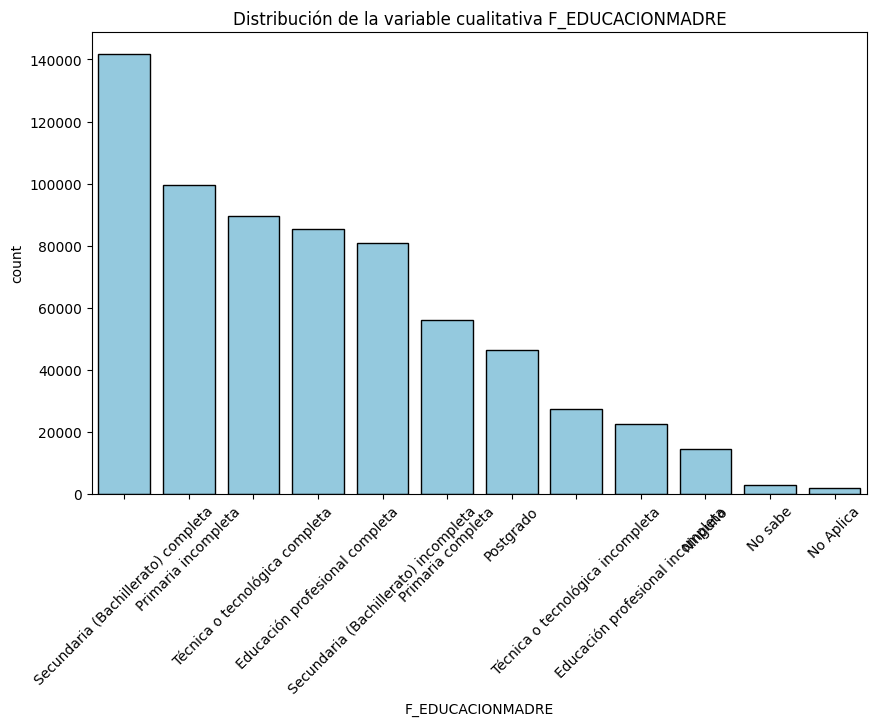

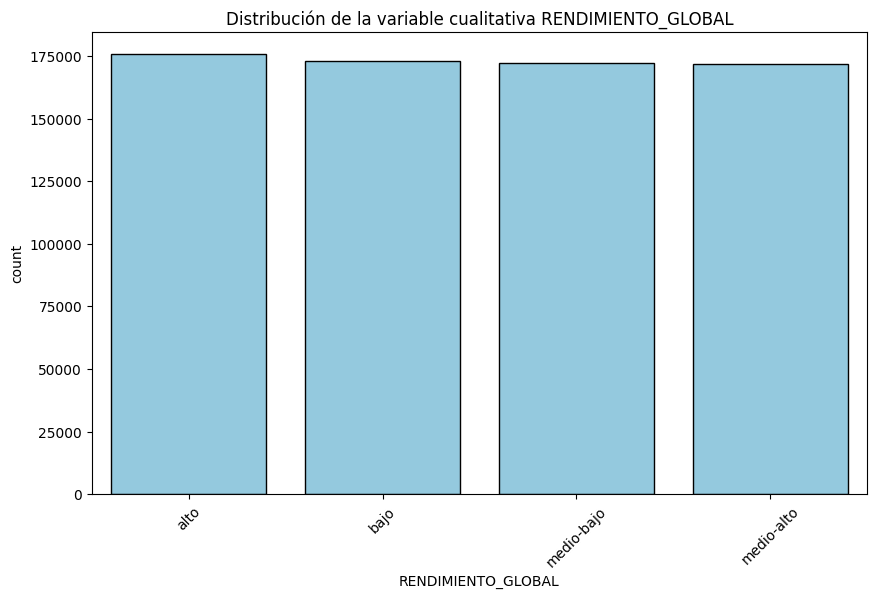

In [10]:
# Distribución de las variables categoricas del dataset

for i, col in enumerate(d.select_dtypes(include=["object"]).columns):

  if i == 0:
    continue # la distribución de E_PRGM_ACADEMICO necesita limpieza

  plt.figure(figsize=(10, 6))
  sns.countplot(data=d, x=col, order=d[col].value_counts().index, color="skyblue", edgecolor="black")
  plt.title(f"Distribución de la variable cualitativa {col}")
  plt.xticks(rotation=45)
  plt.show()

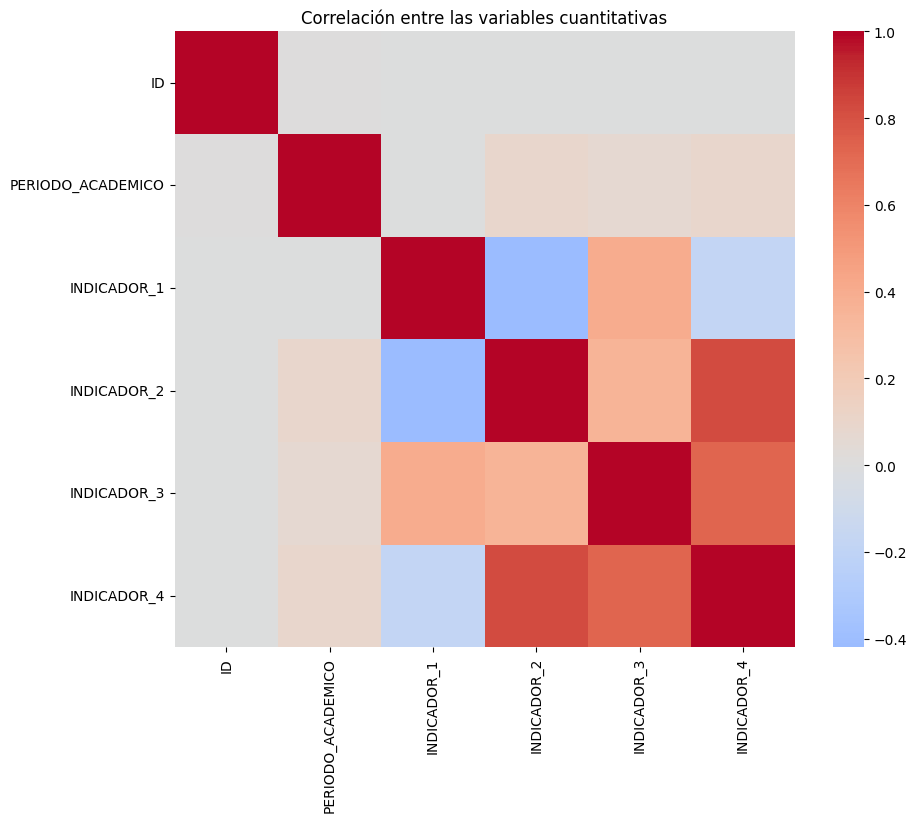

In [11]:
# Mapa de correlapción
plt.figure(figsize=(10, 8))
sns.heatmap(d.corr(numeric_only=True), cmap="coolwarm", center=0)
plt.title("Correlación entre las variables cuantitativas")
plt.show()

## Limpieza y transformación función

al realizar la limpieza del dataset de train y de test cree una función que se encarga de hacer la limpia total de ambos datsets

In [12]:
import pandas as pd
from sklearn.preprocessing import OrdinalEncoder

def clean_dataset(d: pd.DataFrame) -> pd.DataFrame:
    # --- 1. Llenado de valores nulos (solo columnas con menos del 7% de nulos)
    nullValues = d.isnull().sum()
    cols_to_fill = nullValues[nullValues / len(d) < 0.07].index.intersection(d.columns)

    for col in cols_to_fill:
        d[col] = d[col].fillna(d[col].mode()[0])

    # --- 2. Reemplazo de valores en columnas de educación
    if {'F_EDUCACIONMADRE', 'F_EDUCACIONPADRE'}.issubset(d.columns):
        d[['F_EDUCACIONMADRE', 'F_EDUCACIONPADRE']] = d[['F_EDUCACIONMADRE', 'F_EDUCACIONPADRE']].replace({
            'No sabe': 'Ninguno',
            'No Aplica': 'Ninguno'
        })

    # --- 3. Agrupar categorías poco frecuentes en 'E_PRGM_ACADEMICO'
    if 'E_PRGM_ACADEMICO' in d.columns:
        frec = d['E_PRGM_ACADEMICO'].value_counts(normalize=True)
        main_categories = frec[frec > 0.01].index
        d['E_PRGM_ACADEMICO'] = d['E_PRGM_ACADEMICO'].apply(lambda x: x if x in main_categories else 'OTRA')

    # --- 4. One-hot encoding
    def one_hot_columns(df, columns):
        return pd.get_dummies(df, columns=columns, dtype=int)

    columns_for_one_hot = [col for col in ['E_PRGM_ACADEMICO', 'E_PRGM_DEPARTAMENTO'] if col in d.columns]
    if columns_for_one_hot:
        d = one_hot_columns(d, columns_for_one_hot)

    # --- 5. Mapeo de estratos
    extract_mapping = {
        'Sin Estrato': 0,
        'Estrato 1': 1,
        'Estrato 2': 2,
        'Estrato 3': 3,
        'Estrato 4': 4,
        'Estrato 5': 5,
        'Estrato 6': 6
    }
    if 'F_ESTRATOVIVIENDA' in d.columns:
        d['F_ESTRATOVIVIENDA'] = d['F_ESTRATOVIVIENDA'].replace(extract_mapping)

    # --- 6. Definir órdenes de codificación ordinal
    educational_level_order = [
        'Ninguno',
        'Primaria incompleta',
        'Primaria completa',
        'Secundaria (Bachillerato) incompleta',
        'Secundaria (Bachillerato) completa',
        'Técnica o tecnológica incompleta',
        'Técnica o tecnológica completa',
        'Educación profesional incompleta',
        'Educación profesional completa',
        'Postgrado'
    ]

    payment_order = [
        'No pagó matrícula',
        'Menos de 500 mil',
        'Entre 500 mil y menos de 1 millón',
        'Entre 1 millón y menos de 2.5 millones',
        'Entre 2.5 millones y menos de 4 millones',
        'Entre 4 millones y menos de 5.5 millones',
        'Entre 5.5 millones y menos de 7 millones',
        'Más de 7 millones'
    ]

    hours_order = [
        '0',
        'Menos de 10 horas',
        'Entre 11 y 20 horas',
        'Entre 21 y 30 horas',
        'Más de 30 horas'
    ]

    def encode_ordinal_columns(df, column, order):
        if column in df.columns:
            encoder = OrdinalEncoder(categories=[order])
            df[column] = encoder.fit_transform(df[[column]])
        return df

    d = encode_ordinal_columns(d, 'E_HORASSEMANATRABAJA', hours_order)
    d = encode_ordinal_columns(d, 'E_VALORMATRICULAUNIVERSIDAD', payment_order)
    d = encode_ordinal_columns(d, 'F_EDUCACIONMADRE', educational_level_order)
    d = encode_ordinal_columns(d, 'F_EDUCACIONPADRE', educational_level_order)

    # --- 7. Reemplazo binario (Sí/No o S/N)
    def replace_binary_columns(df, columns, mapping):
        for col in columns:
            if col in df.columns:
                df[col] = df[col].map(mapping)
        return df

    # Added 'F_TIENEINTERNET.1' to the list of columns for binary replacement
    cols_si_no = ['F_TIENEINTERNET', 'F_TIENEINTERNET.1', 'F_TIENEAUTOMOVIL', 'F_TIENECOMPUTADOR', 'E_PAGOMATRICULAPROPIO', 'F_TIENELAVADORA']
    cols_s_n = ['E_PRIVADO_LIBERTAD']

    d = replace_binary_columns(d, cols_si_no, {'No': 0, 'Si': 1})
    d = replace_binary_columns(d, cols_s_n, {'N': 0, 'S': 1})

    # --- 8. Reemplazo del rendimiento global
    if 'RENDIMIENTO_GLOBAL' in d.columns:
        try:
            orden_rendimiento = {'bajo': 0, 'medio-bajo': 1, 'medio-alto': 2, 'alto': 3}
            d['RENDIMIENTO_GLOBAL'] = d['RENDIMIENTO_GLOBAL'].replace(orden_rendimiento)
        except Exception as e:
            print(f"An error occurred while replacing RENDIMIENTO_GLOBAL: {e}")

    return d

## Entrenamiento y resultados

El modelo de machine learning sera entrenado en este caso con LogisticRegression como una buena opción para modelos de clasificación.

1. Creación del modelo
2. Entrenamiento
3. Prediccion
4. Acurracy and

In [13]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd

In [14]:
# limpiar y transformar nuestro dataset con la función que anteriormente
# se implemento para transformar el dataset de entrenamiento y el de test
# para la competencia de Kaggle

In [15]:
d = pd.read_csv('train.csv', on_bad_lines='skip')
d = clean_dataset(d)

/tmp/ipython-input-3707085075.py:44: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  d['F_ESTRATOVIVIENDA'] = d['F_ESTRATOVIVIENDA'].replace(extract_mapping)
/tmp/ipython-input-3707085075.py:108: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  d['RENDIMIENTO_GLOBAL'] = d['RENDIMIENTO_GLOBAL'].replace(orden_rendimiento)


In [16]:
d.head(5)

,ID,PERIODO_ACADEMICO,E_VALORMATRICULAUNIVERSIDAD,E_HORASSEMANATRABAJA,F_ESTRATOVIVIENDA,F_TIENEINTERNET,F_EDUCACIONPADRE,F_TIENELAVADORA,F_TIENEAUTOMOVIL,E_PRIVADO_LIBERTAD,...,E_PRGM_DEPARTAMENTO_NORTE SANTANDER,E_PRGM_DEPARTAMENTO_PUTUMAYO,E_PRGM_DEPARTAMENTO_QUINDIO,E_PRGM_DEPARTAMENTO_RISARALDA,E_PRGM_DEPARTAMENTO_SAN ANDRES,E_PRGM_DEPARTAMENTO_SANTANDER,E_PRGM_DEPARTAMENTO_SUCRE,E_PRGM_DEPARTAMENTO_TOLIMA,E_PRGM_DEPARTAMENTO_VALLE,E_PRGM_DEPARTAMENTO_VAUPES
0,904256,20212,6.0,1.0,3,1,5.0,1,1,0,...,0,0,0,0,0,0,0,0,0,0
1,645256,20212,4.0,0.0,3,0,6.0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
2,308367,20203,4.0,4.0,3,1,4.0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
3,470353,20195,5.0,0.0,4,1,0.0,1,0,0,...,0,0,0,0,0,1,0,0,0,0
4,989032,20212,4.0,3.0,3,1,2.0,1,1,0,...,0,0,0,0,0,0,0,0,0,0


In [17]:
# Particionamiento del dataset en los datos de train y de test
d['RENDIMIENTO_GLOBAL']

X = d.drop('RENDIMIENTO_GLOBAL', axis=1)
y = d['RENDIMIENTO_GLOBAL']

xtr, xts, ytr, yts = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

print("Tamaño del dataset original: ", d.shape)
print("Tamaño del dataset de entrenamiento: ", xtr.shape)
print("Tamaño del dataset de test: ", xts.shape)

Tamaño del dataset original:  (692500, 71)
Tamaño del dataset de entrenamiento:  (484750, 70)
Tamaño del dataset de test:  (207750, 70)


In [18]:
!pip install catboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 10.1 MB/s eta 0:00:00


In [40]:
from catboost import CatBoostClassifier

model = CatBoostClassifier(
    iterations=3000,
    learning_rate=0.03,
    depth=6,
    loss_function='MultiClass',
    eval_metric='Accuracy',
    random_seed=42,
    verbose=200,
    od_type='Iter',
    od_wait=80,
    bootstrap_type='Bernoulli',
    subsample=0.7,
    l2_leaf_reg=8
)

model.fit(xtr, ytr)

0:	learn: 0.3637359	total: 350ms	remaining: 17m 30s
200:	learn: 0.4109624	total: 51.5s	remaining: 11m 57s
400:	learn: 0.4189500	total: 1m 38s	remaining: 10m 35s
600:	learn: 0.4241031	total: 2m 25s	remaining: 9m 41s
800:	learn: 0.4267086	total: 3m 12s	remaining: 8m 49s
1000:	learn: 0.4292378	total: 4m	remaining: 8m
1200:	learn: 0.4313254	total: 4m 47s	remaining: 7m 10s
1400:	learn: 0.4329159	total: 5m 34s	remaining: 6m 21s
1600:	learn: 0.4345848	total: 6m 20s	remaining: 5m 32s
1800:	learn: 0.4362145	total: 7m 7s	remaining: 4m 44s
2000:	learn: 0.4376359	total: 7m 55s	remaining: 3m 57s
2200:	learn: 0.4390655	total: 8m 40s	remaining: 3m 9s
2400:	learn: 0.4403115	total: 9m 28s	remaining: 2m 21s
2600:	learn: 0.4418009	total: 10m 15s	remaining: 1m 34s
2800:	learn: 0.4430242	total: 11m 1s	remaining: 47s
2999:	learn: 0.4442290	total: 11m 48s	remaining: 0us


In [41]:
from sklearn.metrics import classification_report, confusion_matrix

y_pred_train = model.predict(xtr)
y_pred = model.predict(xts)

print(classification_report(yts, y_pred))
print(confusion_matrix(yts, y_pred))

              precision    recall  f1-score   support

           0       0.44      0.56      0.49     51896
           1       0.33      0.25      0.29     51682
           2       0.32      0.26      0.29     51486
           3       0.53      0.62      0.57     52686

    accuracy                           0.42    207750
   macro avg       0.41      0.42      0.41    207750
weighted avg       0.41      0.42      0.41    207750

[[28964 10724  7071  5137]
 [19054 13169 11007  8452]
 [11888 10780 13252 15566]
 [ 5275  5158  9622 32631]]


In [42]:
from sklearn.metrics import accuracy_score

accuracy_train = accuracy_score(ytr, y_pred_train)
accuracy_test = accuracy_score(yts, y_pred)
print("Accuracy en el conjunto de entrenamiento:", accuracy_train)
print("Accuracy:", accuracy_test)

Accuracy en el conjunto de entrenamiento: 0.44422898401237754
Accuracy: 0.4236630565583634


In [43]:
# 6. Mostrar si hay overfitting o underfitting

if accuracy_train - accuracy_test > 0.1:
  print("Overfitting")
elif accuracy_test - accuracy_train > 0.1:
  print("Underfitting")
else:
  print("El modelo no tiene Overfitting o Underfitting")

El modelo no tiene Overfitting o Underfitting


### Predicción para la competencia con el test

In [31]:
test = pd.read_csv("test.csv", on_bad_lines='skip')
clean_test = clean_dataset(test)
clean_test

/tmp/ipython-input-3707085075.py:44: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  d['F_ESTRATOVIVIENDA'] = d['F_ESTRATOVIVIENDA'].replace(extract_mapping)


,ID,PERIODO_ACADEMICO,E_VALORMATRICULAUNIVERSIDAD,E_HORASSEMANATRABAJA,F_ESTRATOVIVIENDA,F_TIENEINTERNET,F_EDUCACIONPADRE,F_TIENELAVADORA,F_TIENEAUTOMOVIL,E_PRIVADO_LIBERTAD,...,E_PRGM_DEPARTAMENTO_NORTE SANTANDER,E_PRGM_DEPARTAMENTO_PUTUMAYO,E_PRGM_DEPARTAMENTO_QUINDIO,E_PRGM_DEPARTAMENTO_RISARALDA,E_PRGM_DEPARTAMENTO_SAN ANDRES,E_PRGM_DEPARTAMENTO_SANTANDER,E_PRGM_DEPARTAMENTO_SUCRE,E_PRGM_DEPARTAMENTO_TOLIMA,E_PRGM_DEPARTAMENTO_VALLE,E_PRGM_DEPARTAMENTO_VAUPES
0,550236,20183,1.0,1.0,3,1,6.0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
1,98545,20203,4.0,3.0,2,1,4.0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
2,499179,20212,3.0,0.0,3,1,3.0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
3,782980,20195,3.0,3.0,1,0,1.0,1,0,0,...,0,0,0,0,0,0,1,0,0,0
4,785185,20212,4.0,2.0,2,1,4.0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
296781,496981,20195,4.0,4.0,1,1,1.0,1,1,0,...,0,0,0,0,0,0,0,0,0,0
296782,209415,20183,3.0,0.0,4,1,8.0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
296783,239074,20212,4.0,4.0,3,1,4.0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
296784,963852,20195,6.0,2.0,3,1,8.0,1,0,0,...,0,0,0,0,0,0,0,0,0,0


In [32]:
test = pd.read_csv("test.csv", on_bad_lines="skip")

# Save the original IDs before cleaning and dropping the ID column
test_ids = test['ID']

clean_test = clean_dataset(test)

# Align columns of clean_test with X (training data columns)
missing_cols = set(X.columns) - set(clean_test.columns)
for c in missing_cols:
    clean_test[c] = 0
clean_test = clean_test[X.columns] # Ensure the order of columns is the same

pred_final = model.predict(clean_test)

/tmp/ipython-input-3707085075.py:44: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  d['F_ESTRATOVIVIENDA'] = d['F_ESTRATOVIVIENDA'].replace(extract_mapping)


In [33]:
mapping = {'bajo': 0, 'medio-bajo': 1, 'medio-alto': 2, 'alto': 3}
reverse_mapping = {v: k for k, v in mapping.items()}
final_predictions = [reverse_mapping[p[0]] for p in pred_final]

In [34]:
submission = pd.DataFrame({
    "ID": test_ids, # Use the saved 'ID' column
    "RENDIMIENTO_GLOBAL": final_predictions
})
submission

,ID,RENDIMIENTO_GLOBAL
0,550236,bajo
1,98545,medio-alto
2,499179,alto
3,782980,bajo
4,785185,bajo
...,...,...
296781,496981,medio-bajo
296782,209415,alto
296783,239074,medio-alto
296784,963852,alto


In [35]:
submission.to_csv("submission.csv", index=False)